# Storm Report Denisity Maps

In [1]:
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 30

def mask_data(in_data):
    
    '''
    A defintion masking data in the US, east of the Rockies. 
    
    Parameters
    ----------
    in_data: xarray dataset
    
    Returns
    -------
    out_data: a masked xarray dataset
    
    '''
    
    usa = gpd.read_file("/home/jcorner1/Unidata/shapefiles/smoothing_econus.shp")

    state_mask = regionmask.mask_geopandas(usa, in_data.lon, in_data.lat)
    ma = state_mask.values
    ma[~np.isnan(ma)] = 1

    out_data = in_data * ma
    
    return out_data

In [3]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds_mask: a masked xarray dataset
    
    '''
    geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').max()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    #mask out area 
    ds_mask = mask_data(ds)
    
    
    return ds_mask

In [41]:
#find all the directories for UH and REFC and sorting them.
#print statements are to show what part of the forloop the program is in.
uh_dirts = glob.glob('/home/scratch/ahaberlie/AFWA_2-5KM_UPDRAFT_HELICITY/HIST/*')
uh_dirts.sort()

ref_dirts = glob.glob('/home/scratch/ahaberlie/AFWA_REFLECTIVITY/HIST/*')
ref_dirts.sort()

#create array of same size
arr_djf = np.zeros((899,1399))
arr_mam = np.zeros((899,1399))
arr_jja = np.zeros((899,1399))
arr_son = np.zeros((899,1399))

#iterate through each year (directory)
for dirt_number in range(len(ref_dirts)):
    
    #open all the data within the directory
    print(f'current year: {int(uh_dirts[dirt_number][-4:])-1}')
    uh_ds = xr.open_mfdataset(f'{uh_dirts[dirt_number]}/*HELI_MAX*.nc')
    ref_ds = xr.open_mfdataset(f'{ref_dirts[dirt_number]}/*.nc')
    
    #threshold the data (refc is 50+, UH is 75+)
    print('thresholding')
    thr_refc = ref_ds.where(ref_ds.REFD_COM.values > 50.0, 0)
    thr_uh = uh_ds.where(uh_ds.UP_HELI_MAX.values > 75.0, 0)

    thr_refc = thr_refc.where(thr_refc.REFD_COM.values <= 50, 1)
    thr_uh = thr_uh.where(thr_uh.UP_HELI_MAX.values <= 75, 1)
    
    #Call the values
    vals_uh = thr_uh.UP_HELI_MAX.values
    vals_ref = thr_refc.REFD_COM.values
    
    #multiply values to get areas where both areas are 1
    print('more thresholding')
    vals = vals_uh * vals_ref

    #subset times from dataset
    time = ref_ds.Time.values

    #add the arrays for each season
    print('adding arrays')
    for i in range(len(time)):
        
        try:
            if int(np.datetime_as_string(time[i])[5:7]) >= 3 and int(np.datetime_as_string(time[i])[5:7]) <= 5:
                arr_mam = arr_mam + vals[i,:,:]

            elif int(np.datetime_as_string(time[i])[5:7]) >= 6 and int(np.datetime_as_string(time[i])[5:7]) <= 8:
                arr_jja = arr_jja + vals[i,:,:]

            elif int(np.datetime_as_string(time[i])[5:7]) >= 9 and int(np.datetime_as_string(time[i])[5:7]) <= 11:
                arr_son = arr_son + vals[i,:,:]

            else:
                arr_djf = arr_djf + vals[i,:,:]

        except:
            pass

#nan all zero values        
print('nanning arrays')        
arr_djf[arr_djf==0] = np.nan
arr_mam[arr_mam==0] = np.nan
arr_jja[arr_jja==0] = np.nan
arr_son[arr_son==0] = np.nan

current year: 1990
thresholding
more thresholding
adding arrays
current year: 1991
thresholding
more thresholding
adding arrays
current year: 1992
thresholding
more thresholding
adding arrays
current year: 1993
thresholding
more thresholding
adding arrays
current year: 1994
thresholding
more thresholding
adding arrays
current year: 1995
thresholding
more thresholding
adding arrays
current year: 1996
thresholding
more thresholding
adding arrays
current year: 1997
thresholding
more thresholding
adding arrays
current year: 1998
thresholding
more thresholding
adding arrays
current year: 1999
thresholding
more thresholding
adding arrays
current year: 2000
thresholding
more thresholding
adding arrays
current year: 2001
thresholding
more thresholding
adding arrays
current year: 2002
thresholding
more thresholding
adding arrays
current year: 2003
thresholding
more thresholding
adding arrays
current year: 2004
thresholding
more thresholding
adding arrays
nanning arrays


In [47]:
ds = xr.open_dataset('/home/scratch/ahaberlie/AFWA_2-5KM_UPDRAFT_HELICITY/HIST/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc")

ds = xr.merge([ds, geog.squeeze()])
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')

Text(0.03, 0.05, 'Period: SON HIST (1990 - 2005)')

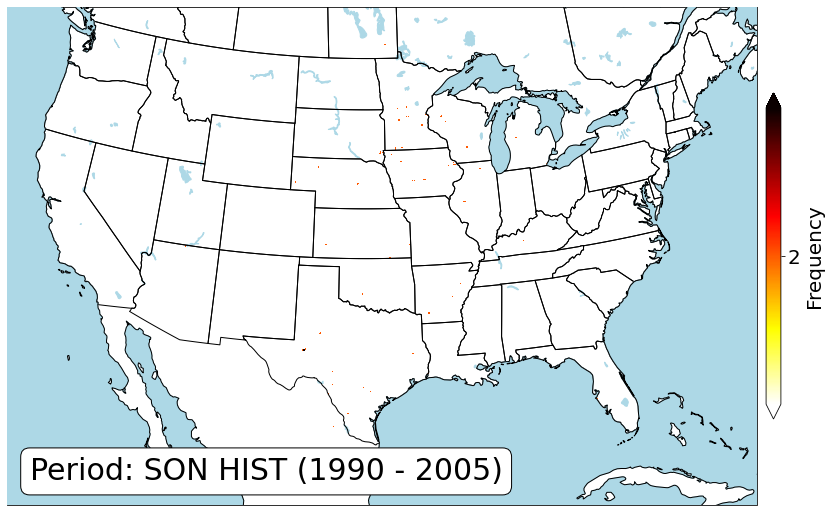

In [55]:
fig = plt.figure()
fig.set_size_inches(16,12)

ax1 = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#c = ax1.pcolormesh(ds.lon, ds.lat, arr_son, transform=cartopy.crs.PlateCarree(), cmap='YlOrBr', shading='nearest')
c = ax1.pcolormesh(ds.lon, ds.lat, arr_son, transform=cartopy.crs.PlateCarree(), cmap='hot_r', shading='nearest')

ax1.add_feature(cartopy.feature.STATES, zorder=2)
ax1.add_feature(cartopy.feature.COASTLINE, zorder = 12)
ax1.add_feature(cartopy.feature.LAND, facecolor='white')
ax1.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder = 11)
ax1.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

ax1.set_extent([-120, -74, 20, 50])


cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, 16, 2)), ax=ax1)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Frequency', size=20)


ax1.annotate(f'Period: SON HIST (1990 - 2005)', (0.03,0.05), xycoords='axes fraction',fontsize=30, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)

In [46]:
#save array for easier use next time. 
np.save(file = f"/home/jcorner1/Unidata/data/HIST_UHREFC_JJA_Storm_Freq_1990-2005.npy", arr = arr_jja)

## Coarsening Data

In [60]:
#find directories for each .nc files
ref_dirts = glob.glob('/home/scratch/ahaberlie/AFWA_REFLECTIVITY/HIST/*')
ref_dirts.sort()

uh_dirts = glob.glob('/home/scratch/ahaberlie/AFWA_2-5KM_UPDRAFT_HELICITY/HIST/*')
uh_dirts.sort()


#create array of same size
arr = np.zeros([44,69])

for dirt_number in range(len(ref_dirts)):
    print(ref_dirts[dirt_number][-4:],uh_dirts[dirt_number][-4:])
    
    #open .nc datasets in the directory
    ref_ds = xr.open_mfdataset(f'{ref_dirts[dirt_number]}/REFD_COM_historical*.nc')
    uh_ds = xr.open_mfdataset(f'{uh_dirts[dirt_number]}/*HELI_MAX*.nc')
    
    #convert datasets to 
    ref_val = Data_Conv(ref_ds)
    uh_val = Data_Conv(uh_ds)
    
    #threshold reflectivity and updraft helicity values.
    print('now thresholding data')
    thr_refc = ref_val.where(ref_val.REFD_COM.values >= 50.0, 0)
    thr_uh = uh_val.where(uh_val.UP_HELI_MAX.values >= 75.0, 0)

    thr_refc = thr_refc.where(thr_refc.REFD_COM.values <= 50, 1)
    thr_uh = thr_uh.where(thr_uh.UP_HELI_MAX.values <= 75, 1)
    
    #call dataset reflectivity values
    vals_ref = thr_refc.REFD_COM.values
    vals_uh = thr_uh.UP_HELI_MAX.values
    
    #Give all areas with a UH of 75+ and reflectivity of 50+ a value of 1. 
    vals = vals_ref * vals_uh
    
    #subset times from dataset
    time = ref_ds.Time.values
    
    #iterate through to sum values in each bin
    print('data is now being added')
    for i in range(len(time)):
        arr = arr + vals[i,:,:]
    
#replace zeros with nans
arr[arr==0] = np.nan

1991 1991



KeyboardInterrupt



/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


Text(0.03, 0.05, 'Period: HIST (1990 - 2005)')

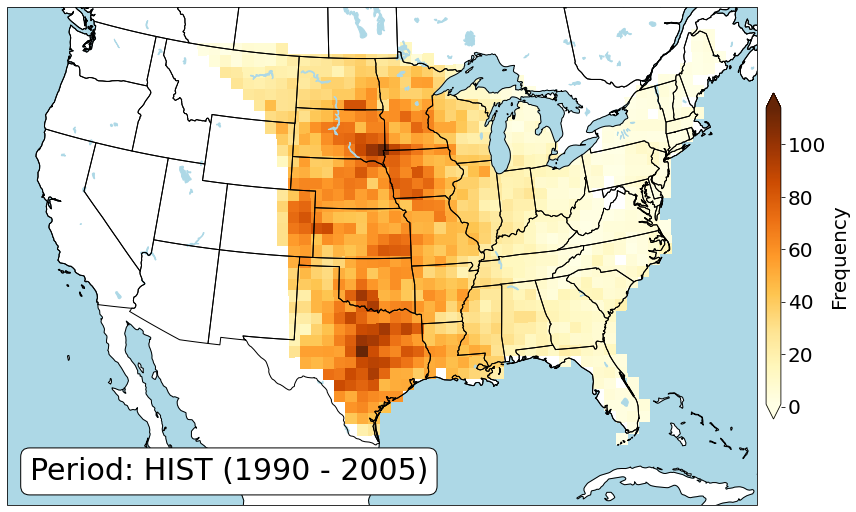

In [22]:
#Plot the data
fig = plt.figure()
fig.set_size_inches(16,12)

ax1 = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

c = ax1.pcolormesh(ref_val.lon, ref_val.lat, arr, transform=cartopy.crs.PlateCarree(), cmap='YlOrBr')

ax1.add_feature(cartopy.feature.STATES, zorder=2)
ax1.add_feature(cartopy.feature.COASTLINE)
ax1.add_feature(cartopy.feature.LAND, facecolor='white')
ax1.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax1.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

ax1.set_extent([-120, -74, 20, 50])


cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, 150, 20)), ax=ax1)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Frequency', size=20)


ax1.annotate(f'Period: HIST (1990 - 2005)', (0.03,0.05), xycoords='axes fraction',fontsize=30, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)

In [56]:
#np.save(file = f"/home/jcorner1/Unidata/data/HIST_UHREFC_Storm_Freq_1990-2005.npy", arr = arr)